In [1]:
# Load Packages

# Some standard linear algebra stuff
using LinearAlgebra
using ExponentialUtilities

# For visualization
using Printf
using LaTeXStrings
using CairoMakie
dark_latexfonts = merge(theme_black(), theme_latexfonts())
set_theme!(dark_latexfonts)

## Create some matrices and plot the dynamics
- 2 real eigenvalues, one stable direction ($\lambda<1$) and one unstable ($\lambda>1$)
- a pair of complex conjugate eigenvalues
    - with $|\lambda|=1$
    - with $|\lambda|<1$

In [2]:
# case 1
P = [2; 1;; 0; 1]
Λ = Diagonal([1.05; 0.8])
A1 = inv(P) * Λ * P

Λ1 = eigvals(A1)
P1 = eigvecs(A1)
println("System 1:")
println(@sprintf("λ1 = %.2f; λ2 = %.2f", Λ1[1], Λ1[2]))
println(@sprintf("v1 = (%.2f / %.2f)", P1[1, 1], P1[2, 1]))
println(@sprintf("v2 = (%.2f / %.2f)", P1[1, 2], P1[2, 2]))


# case 2: Simple rotation (e.g., harmonic oscillator)
ɑ = pi / 6
A2 = [cos(ɑ); sin(ɑ);; -sin(ɑ); cos(ɑ)]

Λ2 = eigvals(A2)
P2 = eigvecs(A2)
println("\nSystem 2:")
println(@sprintf("λ1 = %.2f%+.2fj; λ2 = %.2f%+.2fj", real(Λ2[1]), imag(Λ2[1]), real(Λ2[2]), imag(Λ2[2])))
println(@sprintf("|λ1| = |λ2| = %.2f", abs(Λ2[1])))
println(@sprintf("v1 = (%.2f%+.2fj / %.2f%+.2fj)", real(P2[1, 1]), imag(P2[1, 1]), real(P2[2, 1]), imag(P2[2, 1])))
println(@sprintf("v2 = (%.2f%+.2fj / %.2f%+.2fj)", real(P2[1, 2]), imag(P2[1, 2]), real(P2[2, 2]), imag(P2[2, 2])))

# case 3: Spring-mass-damper system
A3 = exponential!(0.2 * [0; -1;; 1; -0.2])

Λ3 = eigvals(A3)
P3 = eigvecs(A3)
println("\nSystem 3:")
println(@sprintf("λ1 = %.2f%+.2fj; λ2 = %.2f%+.2fj", real(Λ3[1]), imag(Λ3[1]), real(Λ3[2]), imag(Λ3[2])))
println(@sprintf("|λ1| = |λ2| = %.2f", abs(Λ3[1])))
println(@sprintf("v1 = (%.2f%+.2fj / %.2f%+.2fj)", real(P3[1, 1]), imag(P3[1, 1]), real(P3[2, 1]), imag(P3[2, 1])))
println(@sprintf("v2 = (%.2f%+.2fj / %.2f%+.2fj)", real(P3[1, 2]), imag(P3[1, 2]), real(P3[2, 2]), imag(P3[2, 2])))

System 1:
λ1 = 0.80; λ2 = 1.05
v1 = (0.00 / 1.00)
v2 = (0.71 / -0.71)

System 2:
λ1 = 0.87-0.50j; λ2 = 0.87+0.50j
|λ1| = |λ2| = 1.00
v1 = (0.71-0.00j / 0.00+0.71j)
v2 = (0.71+0.00j / 0.00-0.71j)

System 3:
λ1 = 0.96-0.19j; λ2 = 0.96+0.19j
|λ1| = |λ2| = 0.98
v1 = (0.71-0.00j / -0.07-0.70j)
v2 = (0.71+0.00j / -0.07+0.70j)


## Visualize the dynamics

In [3]:
function plotStateSpace(A, P, Λ, nx)
    # box of interest: [-2, 2] ⨉ [-2, 2]
    xmin, xmax = -2, 2

    # create a meshgrid of 21 x 21 points in the 2D state space
    ngrid = 21
    dx = (xmax - xmin) / (ngrid - 1)

    X1 = zeros(ComplexF64, ngrid^2)
    X2 = zeros(ComplexF64, ngrid^2)
    V1 = zeros(ComplexF64, ngrid^2)
    V2 = zeros(ComplexF64, ngrid^2)

    x_ij = zeros(ComplexF64, 2, 1)

    for i in 0 : ngrid - 1
        for j in 0 : ngrid - 1
            k = i * ngrid + j + 1
            X1[k] = xmin + i * dx
            X2[k] = xmin + j * dx

            x_ij[:, 1] = [X1[k], X2[k]]

            v = A * x_ij
            V1[k] = v[1] - x_ij[1, 1]
            V2[k] = v[2] - x_ij[2, 1]
        end
    end

    Vabs = real(sqrt.(V1.^2 .+ V2.^2));

    # nx trajectories of length nt, initiated at random places
    nt = 100
    X = zeros(ComplexF64, (2, nt, nx))
    for i in 1 : nx
        X[:, 1, i] = xmin .+ rand(2) .* (xmax - xmin)
        for k in 2 : nt
            X[:, k, i] = A * X[:, k - 1, i]
        end
    end
    X = real(X);

    # Visualize the vectors and trajectories
    fig = Figure(fontsize = 24, size = (800, 400), backgroundcolor = "black")

    # vectors
    ax1 = Axis(fig[1, 1], xlabel = L"x_1", ylabel = L"x_2", limits=((-2,2), (-2, 2)))
    arrows!(ax1, real(X1), real(X2), real(V1), real(V2), arrowsize = 10, lengthscale = 0.3,
            arrowcolor = Vabs, linecolor = Vabs)
    lines!(ax1, [0, real(P[1,1])], [0, real(P[2,1])], color=:white, linewidth=2)
    lines!(ax1, [0, real(P[1,2])], [0, real(P[2,2])], color=:white, linewidth=2)
    fig

    # trajectories
    ax2 = Axis(fig[1, 2], xlabel = L"x_1", ylabel = L"x_2", limits=((-2,2), (-2, 2)))
    for i in 1 : nx
        lines!(ax2, X[1, :, i], X[2, :, i], color=:white, linewidth=0.5)
    end
    arrows!(ax2, vec(X[1, 1, :]), vec(X[2, 1, :]), vec(X[1, 2, :] - X[1, 1, :]), vec(X[2, 2, :] - X[2, 1, :]), 
            arrowsize = 10, lengthscale = 0.3, arrowcolor = :white, linecolor = :white)
    lines!(ax2, [0, real(P[1,1])], [0, real(P[2,1])], color=:red, linewidth=3)
    lines!(ax2, [0, real(P[1,2])], [0, real(P[2,2])], color=:red, linewidth=3)
    fig
end;

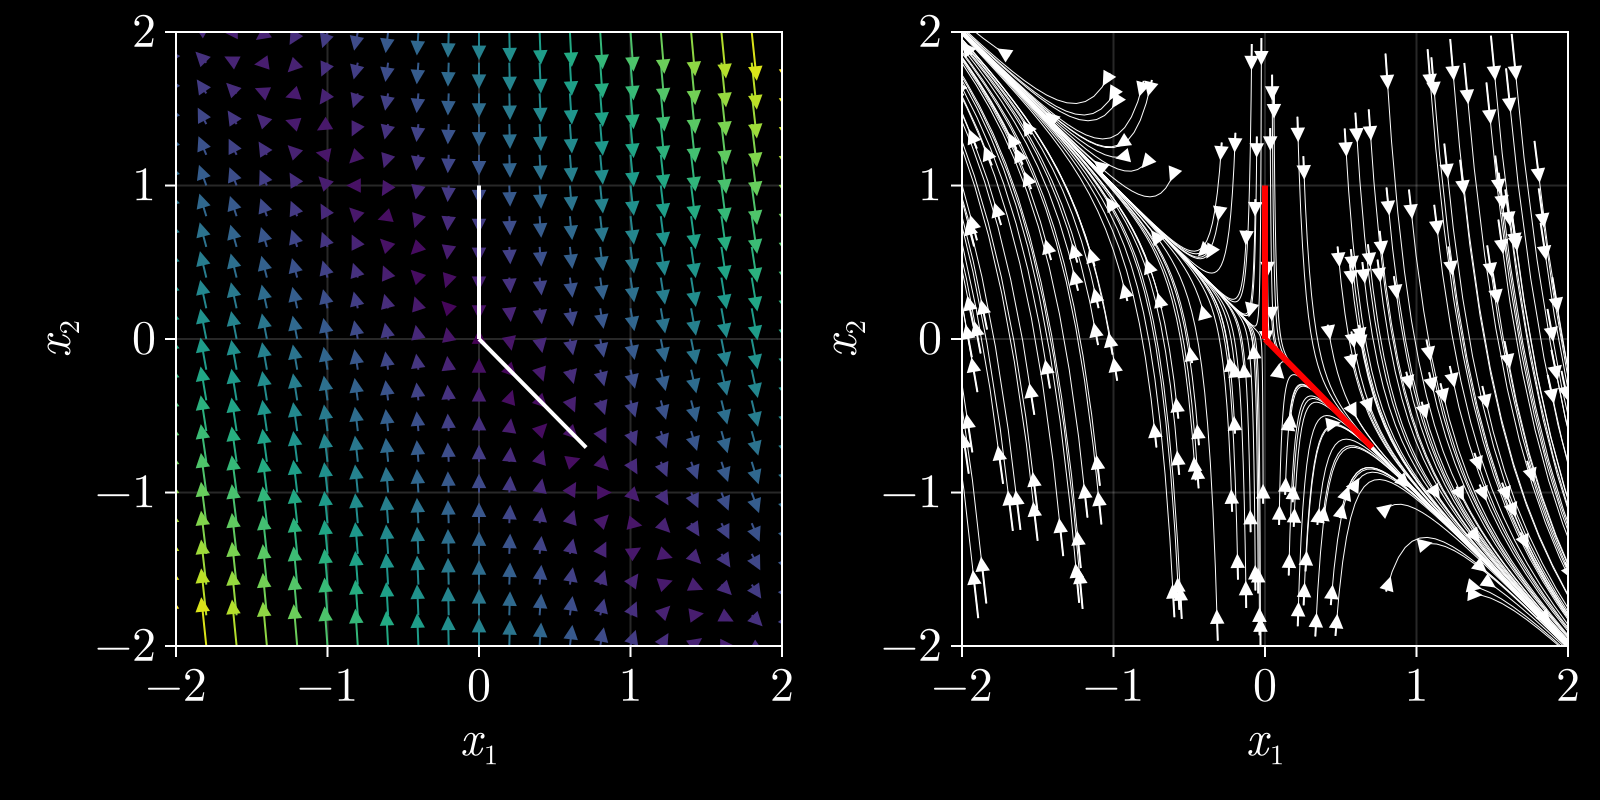

In [4]:
plotStateSpace(A1, P1, Λ1, 200)

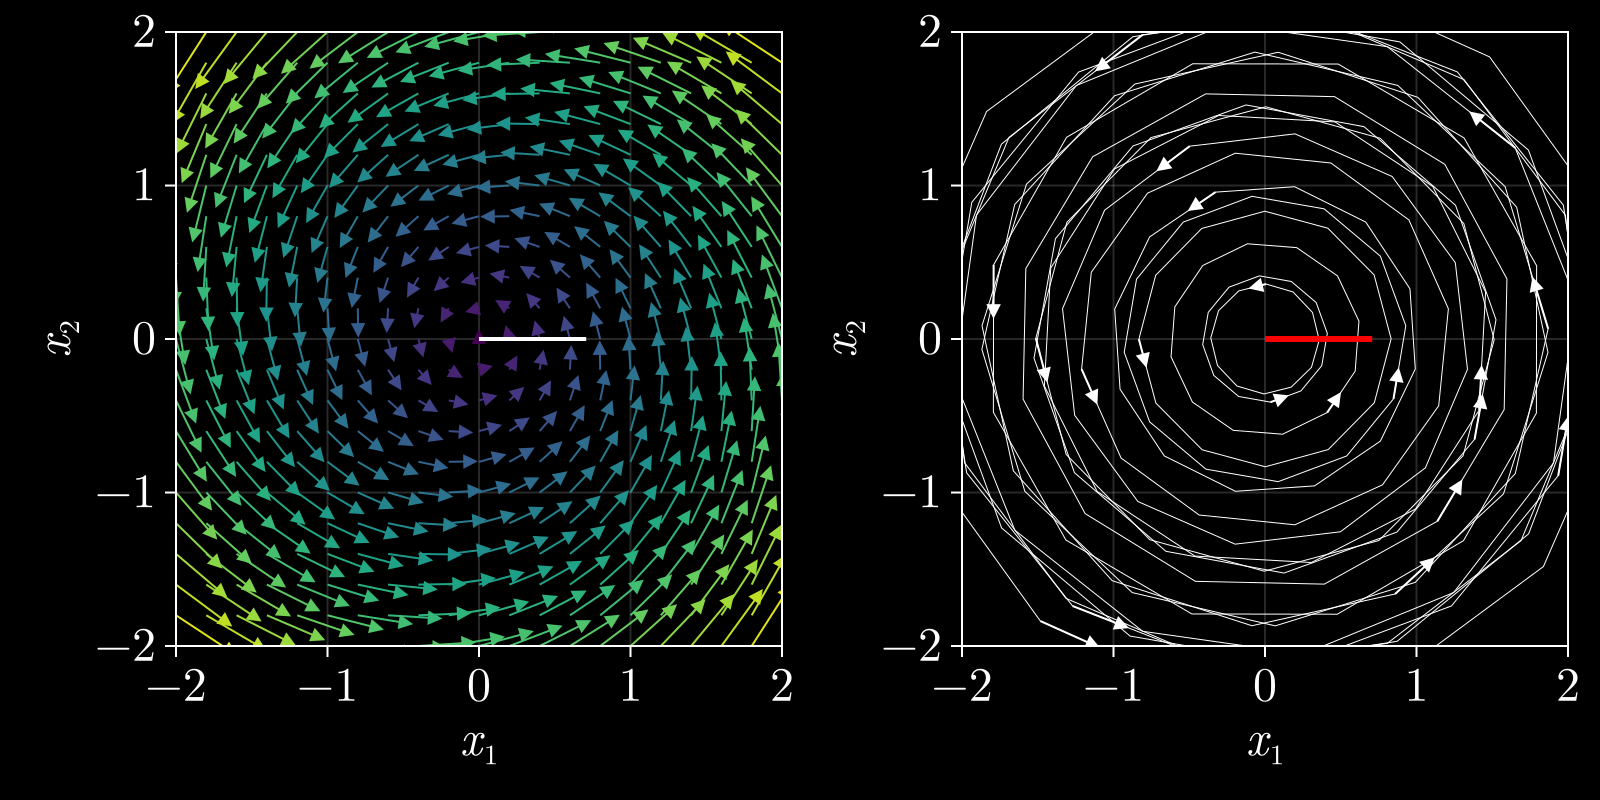

In [7]:
plotStateSpace(A2, P2, Λ2, 20)

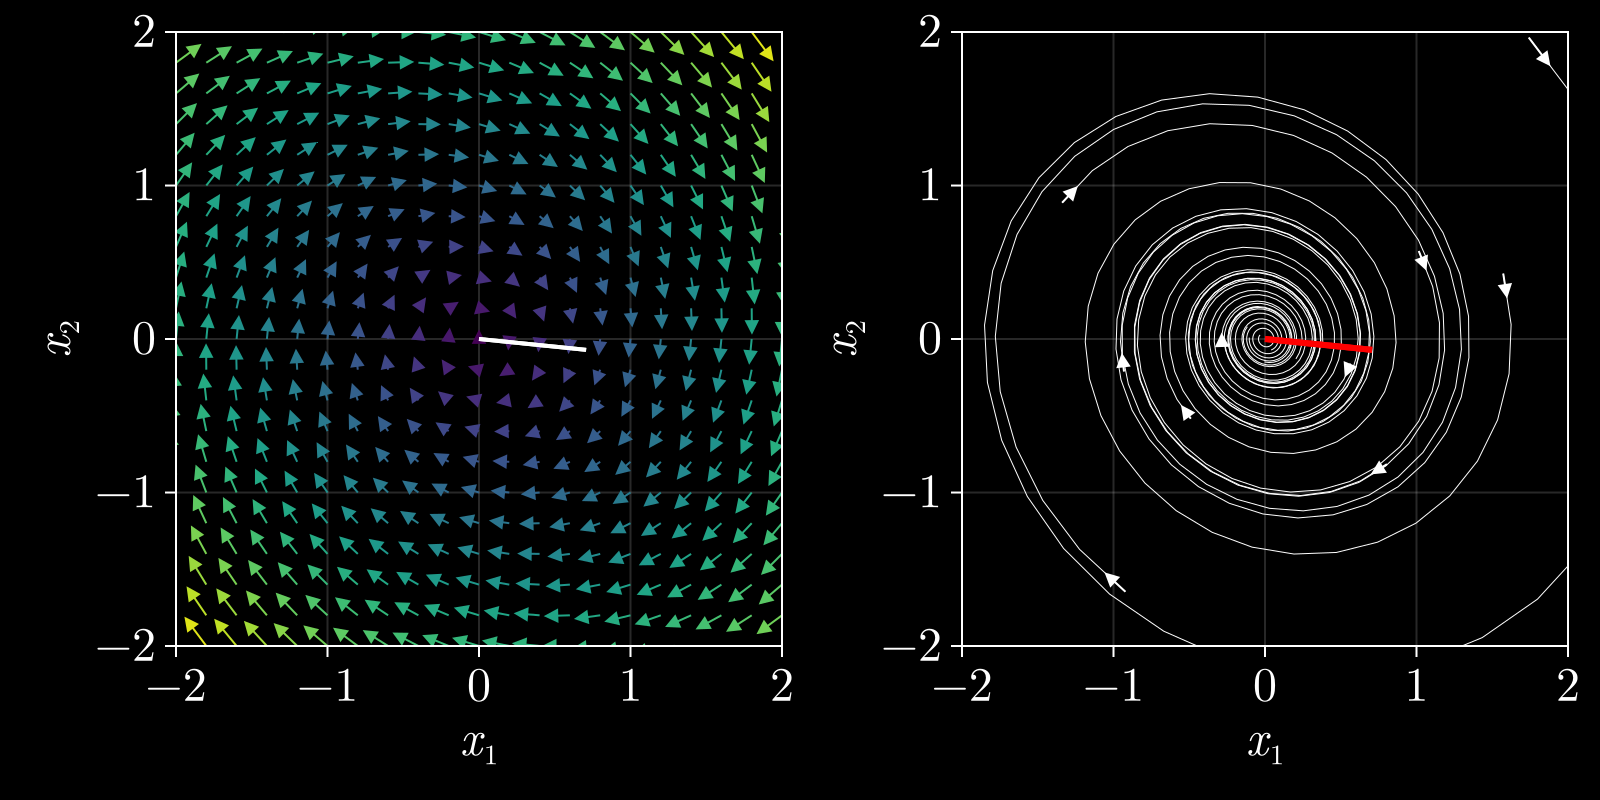

In [6]:
plotStateSpace(A3, P3, Λ3, 10)